In [59]:
import seaborn as sns
import pandas as pd
import getpass
import mysql
import numpy as np
from functions import connect_mysql, mysql_list
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import linregress

# Input User id
try:
    # password input hashed
    id = getpass.getpass("id: ") 
except Exception as ex:
    print('Error Occured : ', ex)
#Input password
try:
    # password input hashed
    pwd = getpass.getpass("password: ") 
except Exception as ex:
    print('Error Occured : ', ex)

#host for RDS connection
host = "mdsi-dsp-spr-2020.cehiwpryiego.ap-southeast-2.rds.amazonaws.com"
mydb = connect_mysql(host, id, pwd)

if mydb: 
    print("Connection Successful")

id: ········
password: ········
Connection Successful


Inspect the df for column labels and data integrity

In [7]:
from functions import mysql_list
mydb = connect_mysql(host, id, pwd)
mycursor = mydb.cursor()
mycursor.execute("SHOW DATABASES;")
# create a list of database
db_list = mysql_list(mycursor.fetchall())
print(db_list) 
# asx is the database to be used
db = "asx"

['asx', 'information_schema', 'mysql', 'performance_schema']


In [8]:
mydb = connect_mysql(host, id, pwd, db)
mycursor = mydb.cursor()
mycursor.execute("SHOW TABLES;")
tb_list = mysql_list(mycursor.fetchall())
print(tb_list)

['ASX200_index', 'GDP_history_year', 'asx200', 'asx200_June_2020', 'asx200_month', 'asx_all', 'asx_history', 'asx_s_and_p', 'australia_GDP_1960_2020_usd', 'cashrate', 'exchange_rate', 'national_net_lending', 'net_lending_borrowing', 'new_loan_commitment_value_properties_purchased', 's_and_p', 'unemployment_rate', 'vix']


In [4]:
from IPython.display import display, HTML
mydb = connect_mysql(host, id, pwd, db)

for tb in tb_list:
    df = pd.read_sql_query("SELECT * FROM %s" % (tb), con=mydb)
    print(tb)


ASX200_index
GDP_history_year
asx200
asx200_June_2020
asx200_month
asx_all
asx_history
asx_s_and_p
australia_GDP_1960_2020_usd
cashrate
exchange_rate
national_net_lending
net_lending_borrowing
new_loan_commitment_value_properties_purchased
s_and_p
unemployment_rate
vix


In [9]:
asx_sp = pd.read_sql_query('SELECT * FROM asx_s_and_p', con = mydb)

asx_sp.set_index('date', inplace=True) ## set the date column as the index for the df

asx_sp

,asx_open,s_and_p_open
date,,
1992-12-01,1452.300049,431.350006
1993-01-01,1576.099976,435.700012
1993-02-01,1538.300049,438.779999
1993-03-01,1652.800049,443.380005
1993-04-01,1676.400024,451.670013
...,...,...
2020-07-01,5897.899902,3105.919922
2020-08-01,5927.799805,3288.260010
2020-09-01,6060.500000,3507.439941


In [105]:
mavg = asx_sp.rolling(window=12).mean()
mavg

,asx_open,s_and_p_open
date,,
1992-12-01,NaN,NaN
1993-01-01,NaN,NaN
1993-02-01,NaN,NaN
1993-03-01,NaN,NaN
1993-04-01,NaN,NaN
...,...,...
2020-07-01,6333.983358,3002.839172
2020-08-01,6260.250000,3028.500834
2020-09-01,6214.941650,3078.369995


<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, 'ASX200 compared with S&P 500 1992 - Present -- Gross trends')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Price')

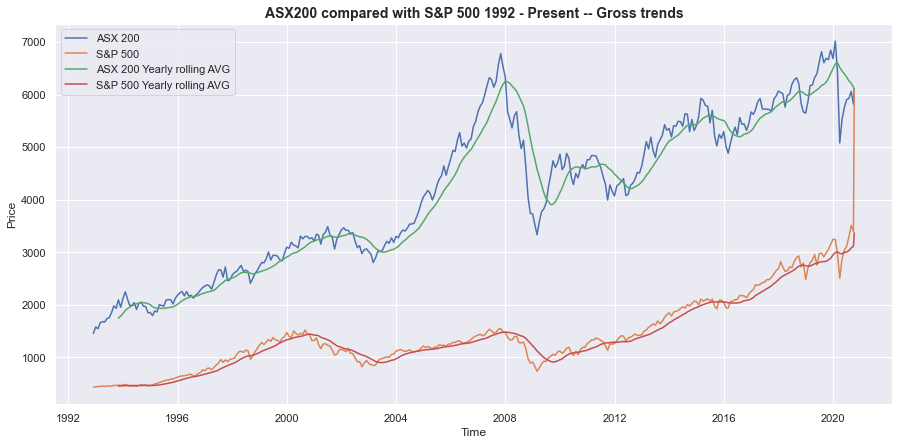

In [11]:
sns.set()

plt.figure(figsize=(15,7))

plt.title('ASX200 compared with S&P 500 1992 - Present -- Gross trends', fontsize = 14, fontweight = 'bold')
asx__sp_plot = plt.plot(asx_sp)
mavg_plot = plt.plot(mavg)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(labels = ['ASX 200','S&P 500', 'ASX 200 Yearly rolling AVG', 'S&P 500 Yearly rolling AVG'])

Findings and Questions for further investigation:
 - The period 2007 to mid 2008 need investigation - what happened in Australia compared with the US markets?
 - It appears the ASX200 is more volatile than the S&P500 across the period. 

<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, 'ASX200 compared with S&P 500 1992 - Present')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Price Difference')

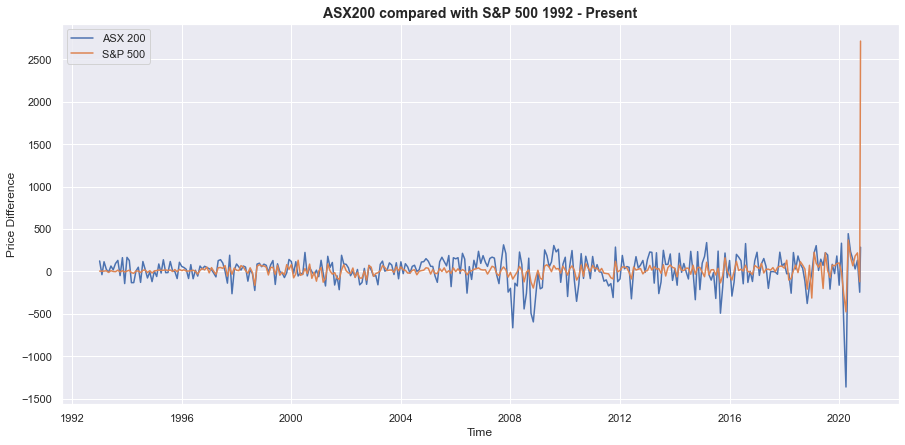

In [12]:
plt.figure(figsize=(15,7))
plt.title('ASX200 compared with S&P 500 1992 - Present', fontsize = 14, fontweight = 'bold')
plt.xlabel('Time')
plt.ylabel('Price Difference')
diff_plot = plt.plot(asx_sp.diff(periods = 1)) ## Get the difference between the months in each columns
plt.legend(labels = ['ASX 200','S&P 500'])

It appears that the ASX is more volatile than the S&P 500. The gains are much greateer but so are the loses in raw figure terms. 

In [184]:
AU_US_corr = asx_sp.pct_change()

array([[<AxesSubplot:xlabel='asx_open', ylabel='asx_open'>,
        <AxesSubplot:xlabel='s_and_p_open', ylabel='asx_open'>],
       [<AxesSubplot:xlabel='asx_open', ylabel='s_and_p_open'>,
        <AxesSubplot:xlabel='s_and_p_open', ylabel='s_and_p_open'>]],
      dtype=object)

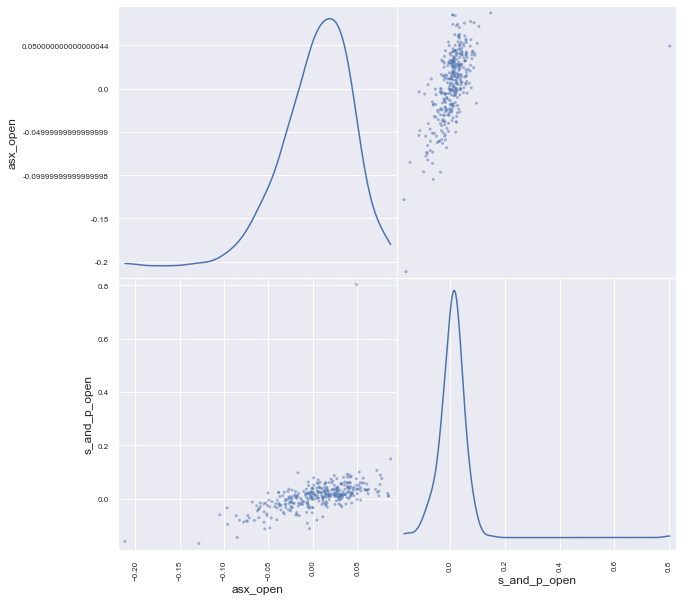

In [68]:
pd.plotting.scatter_matrix(AU_US_corr, diagonal = 'kde', figsize = (10,10))

<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, 'ASX200 and S&P500 correlation')

Text(0.5, 0, 'ASX200')

Text(0, 0.5, 'S&P 500')

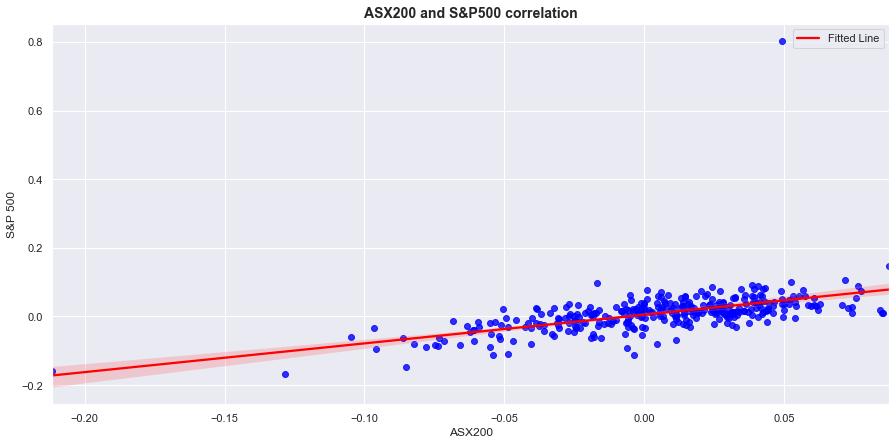

In [37]:
plt.figure(figsize=(15,7))
plt.title('ASX200 and S&P500 correlation', fontsize = 14, fontweight = 'bold')
reg_plot = sns.regplot(x = "asx_open", y = "s_and_p_open", data = AU_US_corr,
           scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel('ASX200')
plt.ylabel('S&P 500')
plt.legend(labels = ['Fitted Line'])

In [38]:
asx_sp.corr(method = "pearson")

,asx_open,s_and_p_open
asx_open,1.000000,0.811909
s_and_p_open,0.811909,1.000000


In [39]:
AU_US_corr.corr(method = "pearson")

,asx_open,s_and_p_open
asx_open,1.000000,0.535695
s_and_p_open,0.535695,1.000000


In [44]:
shift_1 = asx_sp['asx_open'].autocorr(lag=1)
shift_1

0.9925100124421418

In [45]:
shift_2 = asx_sp['s_and_p_open'].autocorr(lag=1)
shift_2

0.9756126170492978

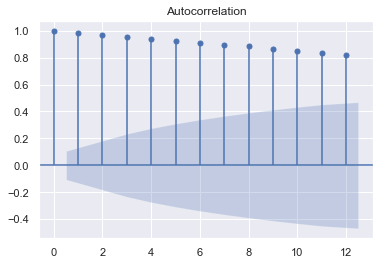

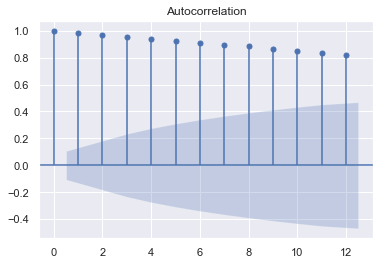

In [183]:
plot_acf(asx_sp['asx_open'], lags=12)
plt.show()

<Figure size 432x288 with 0 Axes>

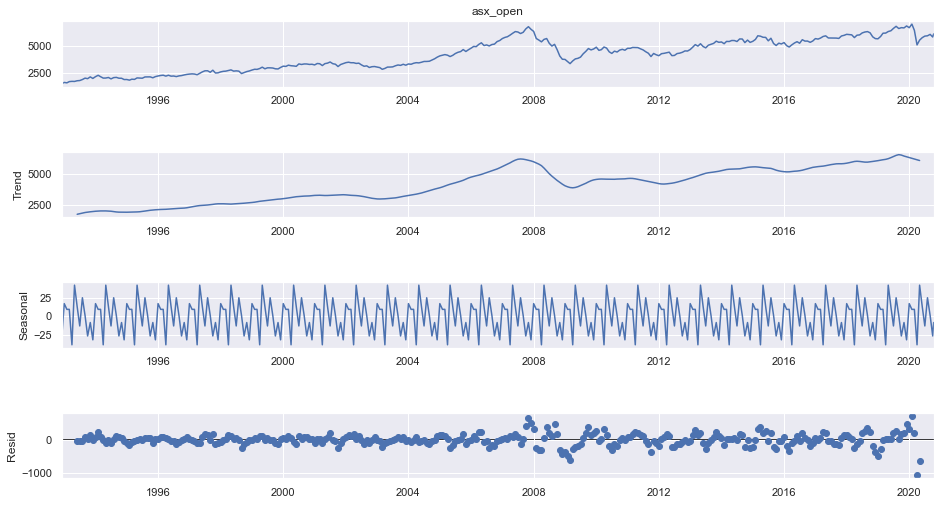

In [63]:
decomposition = seasonal_decompose(asx_sp.asx_open, period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

<Figure size 432x288 with 0 Axes>

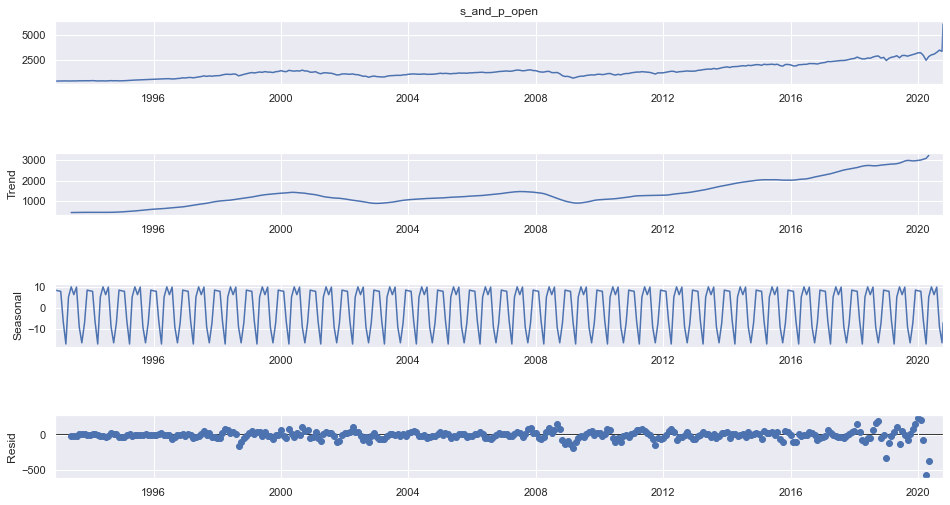

In [65]:
decomposition = seasonal_decompose(asx_sp.s_and_p_open, period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [157]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag = 12,regression = 'ctt', autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 

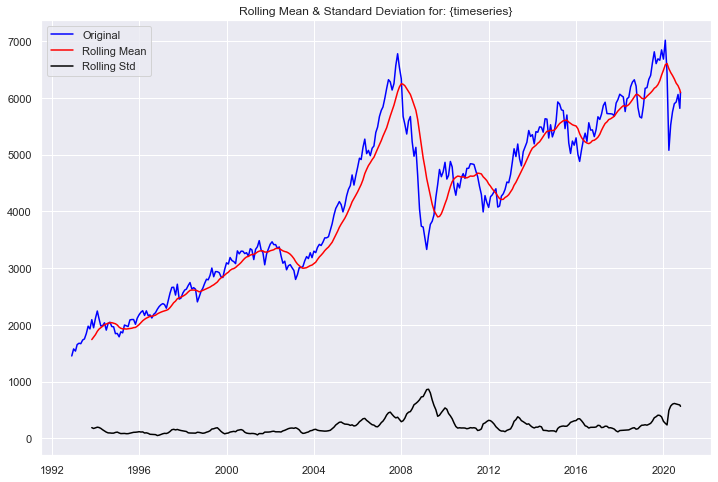

Results of Dickey-Fuller Test:
Test Statistic                  -3.072982
p-value                          0.261590
#Lags Used                       1.000000
Number of Observations Used    334.000000
Critical Value (1%)             -4.406155
Critical Value (5%)             -3.850187
Critical Value (10%)            -3.564266
dtype: float64


In [138]:
test_stationarity(asx_sp.asx_open)

In [180]:
first_difference = pd.DataFrame(asx_sp.asx_open - asx_sp.asx_open.shift(3)).dropna(inplace = False)
print(first_difference)

              asx_open
date                  
1993-03-01  200.500000
1993-04-01  100.300049
1993-05-01  130.399902
1993-06-01   80.000000
1993-07-01   75.900024
...                ...
2020-07-01  821.100098
2020-08-01  405.399902
2020-09-01  304.799805
2020-10-01  -82.000000
2020-10-12  174.400391

[333 rows x 1 columns]


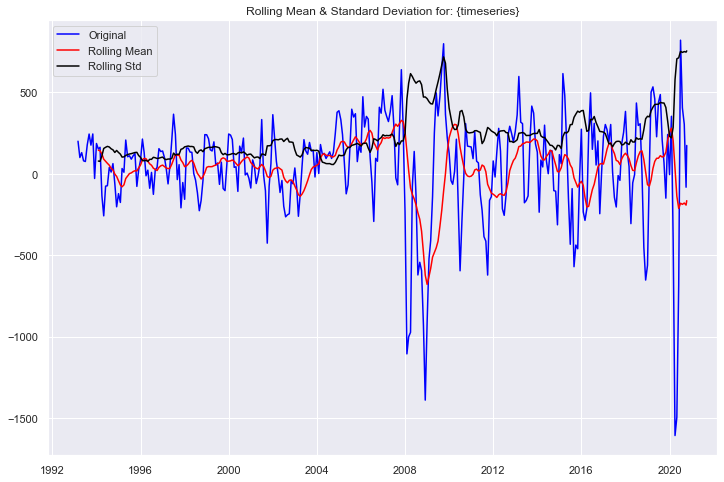

Results of Dickey-Fuller Test:
Test Statistic                  -5.091984
p-value                          0.000711
#Lags Used                      12.000000
Number of Observations Used    320.000000
Critical Value (1%)             -4.407703
Critical Value (5%)             -3.850971
Critical Value (10%)            -3.564750
dtype: float64


In [181]:
test_stationarity(first_difference.dropna(inplace = False))

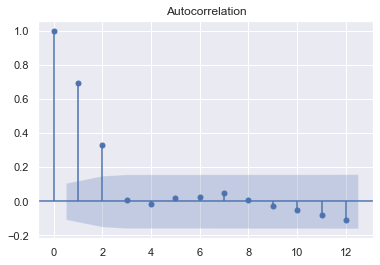

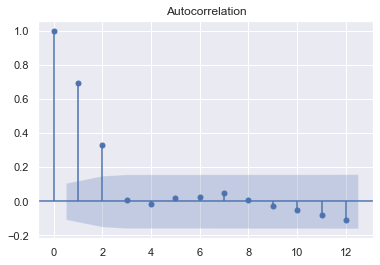

In [182]:
plot_acf(first_difference, lags=12)
plt.show()

In [234]:
def crosscorr(datax, datay, lag=0,wrap=False):
    """ Lag-N cross correlation.
    Shifted data filled with NaNs
    
    Parameters
    ---
    lag: int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ---
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shifted.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else:
        return datax.corr(datay.shift(lag))

[Text(0.5, 1.0, 'Offset = 190.0 months \nASX 200 leads <> S&P 500 leads'),
 Text(0.5, 0, 'Offset'),
 Text(0, 0.5, 'Pearson r')]

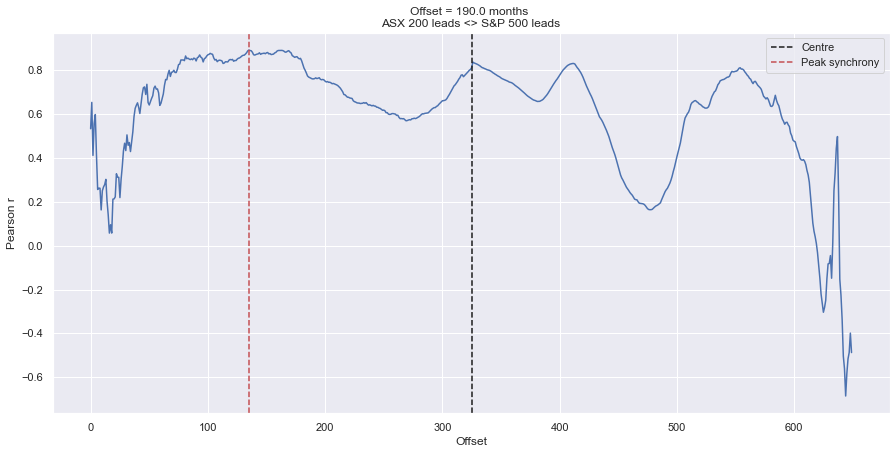

In [269]:
d1 = asx_sp.asx_open
d2 = asx_sp.s_and_p_open
month = 325
rs = [crosscorr(d1,d2,lag) for lag in range(-int(month),int(month))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)

f,ax=plt.subplots(figsize=(15,7))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k', linestyle='--',label='Centre')
ax.axvline(np.argmax(rs),color='r', linestyle='--', label='Peak synchrony')
ax.set(title=f'Offset = {offset} months \nASX 200 leads <> S&P 500 leads', xlabel = 'Offset', ylabel='Pearson r')
plt.legend()